Note: assuming constant (spacial) gravity will affect my results and comparisons, temporal is too small to matter. This would make correlations more valid that rmse (?), but it's under 1% (ref to wikipedia)

I'm not sure what density CSR uses to generate ewh/lwe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import cartopy.crs as ccrs
import scipy.optimize
import time
import h5py

min_bpr_len = 1 #(years)

plt.figure()
mm = 1/25.4
plt.rcParams.update({'font.size': 8,'figure.dpi':150})

<Figure size 640x480 with 0 Axes>

In [2]:
import scipy.stats

In [3]:
import importlib
import sys
sys.path.append('..')
import ANU_mascon_lookup

importlib.reload(ANU_mascon_lookup)

<module 'ANU_mascon_lookup' from '/Users/u6955431/Documents/Honours/code_environment/GRACEvsBPR/../ANU_mascon_lookup.py'>

In [4]:
lg_dataset_dir = '/Users/u6955431/Large_Datasets/GRACE_solutions/'

### Wrangle new ANU solutions

In [5]:
def new_lookup_mascon(primary_list, 
                      ternary_list,
                  lonlat):
        
    '''lonlat is an array with shape (2, ...), although a 1D tuple or list should also work'''

    def to_xyz(lonlat):
        '''Turns longitude and latitude coordinates into x,y,z coordinates
        Spherical earth is sufficient for determining the nearest ternary mascon
        This is just a way of making sure I can wrap around 360 and that nearest longitude 
        doesn't dominate like it would at the poles in euclidian lat/lon distance

        lonlat is an array with shape (2, ...), although a 1D tuple or list should also work'''

        #Using trig identity cheats halves the time this function takes - possibly worth implementing but be careful
        #of Nans from sqrt(-0.0001) type things

        lon = lonlat[0]
        lat = lonlat[1]

        #Attempt to make sure lat & lon are the right way around
        assert np.all(np.abs(lat)<91), 'lat outside of range: '+str(lat[np.abs(lat)>91])
        R_E = 6.371*10**6 #Earth's radius

        z = np.sin(np.deg2rad(lat))  *R_E
        xy = np.cos(np.deg2rad(lat))  *R_E
        x = np.cos(np.deg2rad(lon))*xy #I'm not certain these are conventionally defined (x & y might be swapped), 
        y = np.sin(np.deg2rad(lon))*xy #but it doesn't matter for this application.

        return np.int32(np.array((x,y,z))) #1m accuracy is way too good anyway
    
    print('Building mascon lookup tree (~60 seconds)')    
    
    ternary_xyz = to_xyz(np.array(ternary_list).T).T
    ternary_tree = scipy.spatial.KDTree(ternary_xyz)

    tree_to_primary = primary_list
        
  
    input_xyz = to_xyz(lonlat)
    
    #Actual heavy lifting. Possibly 30 minutes
    print('Starting lookup for supplied indices. This could take a while \n \
(~2 min? It took 30 min once but I haven\'t been able to replicate that)')
    distances, indexes = ternary_tree.query(input_xyz.T)
    print('Finished mascon lookup')
    return tree_to_primary[indexes]


In [6]:
f = h5py.File(lg_dataset_dir+'b9ti10gia_reg1.0_noCoM_corrected.h5', "r")
f2 = h5py.File(lg_dataset_dir+'mascons_stage5_V008_200km.h5', "r")

anu_T = np.array((f2['mascons']['T']['lon'],f2['mascons']['T']['lat'])).T
anu_P = np.array(f2['mascons']['T']['primary'])

ANU_mascons = xr.DataArray(f['solution']['ewh'][()]).rename({'dim_0':'nbt','dim_1':'nbp'}).assign_coords({'nbp':np.arange(12755)+1,'nbt':f['time']['decyear']})

ANU_mascons = ANU_mascons*9.806*1029 *10**-4

### Other two processing centres (easier to work with)

In [8]:
JPL_mascons = xr.load_dataset(lg_dataset_dir+'/GRCTellus.JPL.200204_202302.GLO.RL06.1M.MSCNv03.nc')
JPL_mascons = JPL_mascons.rename({'time':'decyear'}) #Newest version of xarray is unhappy with this
JPL_mascons = JPL_mascons.assign_coords({'decyear':(JPL_mascons.decyear-np.datetime64('2000-01-01'))/np.timedelta64(1,'ns')/10**9/3600/24/365.24+2000})
JPL_mascons = JPL_mascons.lwe_thickness*9.806*1000*10**-6 #dbar

In [9]:
CSR_mascons = xr.load_dataset(lg_dataset_dir+'CSR_GRACE_GRACE-FO_RL0602_Mascons_all-corrections.nc')
CSR_mascons = CSR_mascons.rename({'time':'decyear'})
CSR_mascons = CSR_mascons.assign_coords({'decyear':(CSR_mascons.decyear/365.25+2002)})
CSR_mascons = CSR_mascons.lwe_thickness*9.806*1000*10**-6 #dbar (Not sure if density is correct

In [10]:
GSFC_mascons = xr.load_dataset(lg_dataset_dir+'gsfc.glb_.200204_202305_rl06v2.0_obp-ice6gd_halfdegree.nc')
GSFC_mascons = GSFC_mascons.rename({'time':'decyear'})
GSFC_mascons = GSFC_mascons.assign_coords({'decyear':(GSFC_mascons.decyear-np.datetime64('2000-01-01'))/np.timedelta64(1,'ns')/10**9/3600/24/365.24+2000})
GSFC_mascons = GSFC_mascons.lwe_thickness*9.806*1000*10**-6

In [11]:
GRACE_epochs = np.arange(2002,2016,1/12)+1/24

In [12]:
#Read in BPR data, averaging to align timeseries and subselecting GRACE data to match
all_files = glob.glob('/Users/u6955431/Large_Datasets/PSMSL_OBP/data/*_drp.txt', recursive=True)

#Initialise empty lists for timeseries
anu = []
jpl = []
csr = []
gsfc = []
bpr = [] #Bottom pressure recorders

lons = []
lats = []

#For each BPR in the PSMSL database
#Extract metadata
for filepath in all_files:
    #Retrieve metadata for this station
    file = filepath.split('/')[-1]
    with open(filepath,'r') as inputFile:
        lat = None
        lon = None
        while (lat is None) or (lon is None):
            line = inputFile.readline().split()
            if len(line)<2:
                continue
            if line[0] == 'Latitude':
                lat = float(line[-1])
            if line[0] == 'Longitude':
                lon = float(line[-1])
    lons.append(lon)
    lats.append(lat)

lons = np.array(lons)
lats = np.array(lats)
mascon_id = new_lookup_mascon(anu_P,anu_T,(lons,lats))
keepdata = np.zeros(lons.shape,dtype=bool)    
#Process OBP data
for i,filepath in enumerate(all_files):
    
    #Read in BPR data
    data = np.loadtxt(filepath,skiprows=22).T
    obp = data[5]
    obp[obp<-999] = np.nan                      #Sensor data, in mbar
    obp_decyear = data[2]+(data[3]-1)/365.25    #Recording time (+- 1 day) in decimal year format
    
    
        
    #Identify months with sufficient data for a comparison
    epochs = GRACE_epochs[np.where((GRACE_epochs>obp_decyear[0]) & (GRACE_epochs<obp_decyear[-1]))]
    
    #Keep only data which spans more than a year and is not missing more than a month
    if (len(epochs)<min_bpr_len*12) or np.any(np.diff(obp_decyear)>1/12):
        continue
    keepdata[i] = True
    
    #Extract relevant GRACE data
    anu.append(ANU_mascons.sel(nbt = epochs,nbp=mascon_id[i],method='nearest')) #Nearest adjusts for slight changes in epoch definitions between products
    jpl.append(JPL_mascons.sel(decyear = epochs,lat = lats[i], lon = lons[i]%360,method='nearest'))
    csr.append(CSR_mascons.sel(decyear = epochs,lat = lats[i], lon = lons[i]%360,method='nearest'))
    gsfc.append(GSFC_mascons.sel(decyear = epochs,lat = lats[i], lon = lons[i]%360,method='nearest'))
    
    #Average BPR data to create a comparable timeseries
    fake_grace = np.zeros(epochs.shape)
    for j,e in enumerate(epochs):
        min_time = float(e-1/24) #Epochs are defined by the middle of the month
        max_time = float(e+1/24)
        fake_grace[j] = np.nanmean(obp[(obp_decyear>=min_time)&(obp_decyear<=max_time)])/10**2 #dbar (from mbar)
    bpr.append(fake_grace)
    
lons = lons[keepdata]
lats = lats[keepdata]
mascon_id = mascon_id[keepdata]

Building mascon lookup tree (~60 seconds)
Starting lookup for supplied indices. This could take a while 
 (~2 min? It took 30 min once but I haven't been able to replicate that)
Finished mascon lookup


/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_19538/1627885877.py:67: RuntimeWarning: Mean of empty slice
  fake_grace[j] = np.nanmean(obp[(obp_decyear>=min_time)&(obp_decyear<=max_time)])/10**2 #dbar (from mbar)
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_19538/1627885877.py:67: RuntimeWarning: Mean of empty slice
  fake_grace[j] = np.nanmean(obp[(obp_decyear>=min_time)&(obp_decyear<=max_time)])/10**2 #dbar (from mbar)
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_19538/1627885877.py:67: RuntimeWarning: Mean of empty slice
  fake_grace[j] = np.nanmean(obp[(obp_decyear>=min_time)&(obp_decyear<=max_time)])/10**2 #dbar (from mbar)
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_19538/1627885877.py:67: RuntimeWarning: Mean of empty slice
  fake_grace[j] = np.nanmean(obp[(obp_decyear>=min_time)&(obp_decyear<=max_time)])/10**2 #dbar (from mbar)
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_19538/1627885877.py:67: RuntimeWarnin

In [13]:
def detrend(y,x=None):
    if x is None:
        x = np.arange(len(y))
    nn = ~np.isnan(y)
    if np.sum(nn) == 0:
        return y
    m,c,*_ = scipy.stats.linregress(x[nn],y[nn])
    return y-m*x-c

In [14]:
percent_of_actual = {} 
err = {}
pm_err = {}
j_err = {}

for t in ('','dt'): #Detrended or not
    for loc in ('anu','jpl','csr','gsfc'): #Which dataset to use
        poa_list = np.zeros(0)
        err_list = np.zeros(0)
        pm_err_list = np.zeros(0)
        j_err_list = np.zeros(0)
        
        #What data do we acutally want with those parameters
        if loc == 'anu':
            grace_data = anu
        elif loc == 'jpl':
            grace_data = jpl
        elif loc == 'csr':
            grace_data = csr
        elif loc == 'gsfc':
            grace_data = gsfc
        
        #Step through each station and calculate
        for i in range(len(bpr)):
            A = grace_data[i].data
            B = bpr[i]
            if t == 'dt':
                A = detrend(A)
                B = B
            else:
                A = A-np.mean(A)
                B = B-np.mean(B)
            adj_A = A+0.006*np.abs(B)/B
            
            poa_list = np.concatenate((poa_list,np.array((A-B)/B)))
            err_list = np.concatenate((err_list,np.array((A-B))))
            pm_err_list = np.concatenate((pm_err_list, np.array((A-B)*np.abs(B)/B)))
            j_err_list = np.concatenate((j_err_list, np.array((adj_A-B)*np.abs(B)/B)))
        
        percent_of_actual[(loc,t)] = np.array(poa_list)    #Store calculated stats in a dictionary for easy plotting
        err[(loc,t)] = np.array(err_list)
        pm_err[(loc,t)] = np.array(pm_err_list)
        j_err[(loc,t)] = np.array(j_err_list)

In [15]:
#Trying to work out if error is even roughly normal.
cc = {}    #Correlation coefficient
rmse = {}  #Root mean square error

for t in ('','dt'): #Detrended or not
    for loc in ('anu','jpl','csr','gsfc'): #Which dataset to use
        cc_list = []
        rmse_list = []
        f_list = []
        
        #What data do we acutally want with those parameters
        if loc == 'anu':
            grace_data = anu
        elif loc == 'jpl':
            grace_data = jpl
        elif loc == 'csr':
            grace_data = csr
        elif loc == 'gsfc':
            grace_data = gsfc
        
        #Step through each station and calculate
        for i in range(len(bpr)):
            A = grace_data[i].data
            B = bpr[i]
            if t == 'dt':
                A = detrend(A)
                B = detrend(B)
            else:
                A = A-np.mean(A)
                B = B-np.mean(B)
            
            cc_list.append(np.corrcoef(A,B)[0,1])
            rmse_list.append(np.sqrt(np.mean((A-B)**2)))
        
        cc[(loc,t)] = np.array(cc_list)    #Store calculated stats in a dictionary for easy plotting
        rmse[(loc,t)] = np.array(rmse_list)

0.5093616485770043 jpl
0.539603463931414 csr
0.4898697666543865 gsfc
0.4574303601988139 anu


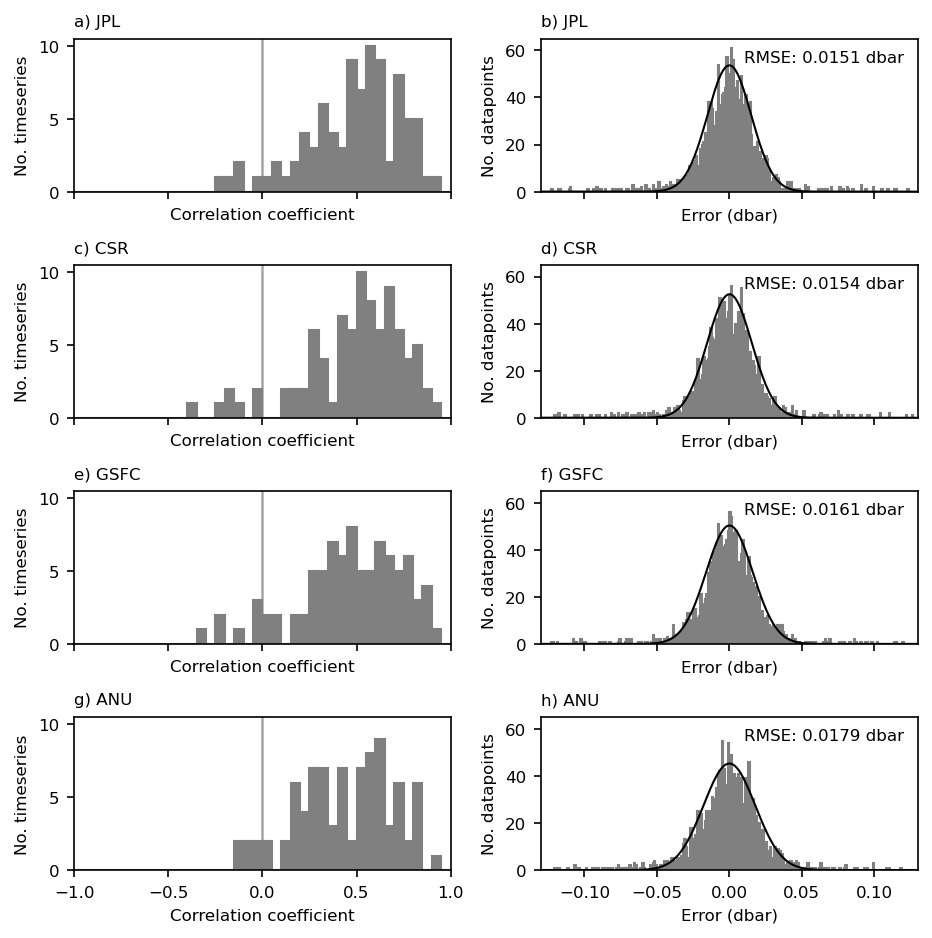

In [19]:
fig, ax = plt.subplots(4,2,figsize=(160*mm,160*mm),sharey = False,sharex='col')
letters = 'abcdefghijklmnop'

for loc_i, loc in enumerate(('jpl','csr','gsfc','anu')):

    

    j=0
    ax[loc_i,j].hist(cc[(loc,'')],bins = np.arange(-1,1.05,0.05),density=False,color='gray',edgecolor='gray')
    plt.sca(ax[loc_i,j])
    #plt.yticks([])
    print(np.nanmedian(cc[(loc,'')]),loc)
    plt.xlim(-1,1)
    
    plt.axvspan(0,0.002,color='gray',zorder=-4,alpha=0.5)
    plt.xticks((-1,-0.5,0,0.5,1))


    j=1
    ax[loc_i,j].hist(err[(loc,'')],bins = np.arange(-0.2,0.2,0.001),density=False,color='gray',edgecolor='gray')
    plt.sca(ax[loc_i,j])
    #plt.yticks([])
    
    #Iterate to find an outlier-robust standard deviation
    std = 1
    prev_std = 10
    while prev_std-std>0.001:
        data = err[(loc,'')][np.abs(err[(loc,'')])<std*3]
        prev_std = std
        std = np.std(data)
        mean = np.nanmean(data)
        x = np.arange(-0.2,0.2,0.001)
    plt.plot(x,scipy.stats.norm.pdf(x,mean,std)*err[(loc,'')].shape[0]*0.001,c='k',linewidth=1)
    plt.xlim(-0.13,0.13)
    
    plt.text(0.01,55,'RMSE: '+str(round(std,4))+' dbar')

    ax[loc_i,0].set_title(letters[loc_i*2  ]+') '+loc.upper(),loc='left',fontsize=8)
    ax[loc_i,1].set_title(letters[loc_i*2+1]+') '+loc.upper(),loc='left',fontsize=8)
    
    ax[loc_i,0].set_ylabel('No. timeseries')
    ax[loc_i,0].set_ylim(0,10.5)
    
    ax[loc_i,1].set_ylabel('No. datapoints')
    ax[loc_i,1].set_ylim(0,65)

    ax[loc_i,1].set_xlabel('Error (dbar)')
    ax[loc_i,0].set_xlabel('Correlation coefficient')

plt.tight_layout()

plt.savefig('../thesis_images/paper_GRACE_validation.pdf')